In [1]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import sys
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

In [2]:
IMAGE = '../data/external_test_data/bacterial_spot/bacterial-symptoms-pepper.jpg'
MODEL = keras.models.load_model('../models/trained_transparency_larger_subset.h5')
CLASSES = [
    'alternaria_leaf_spot',
    'bacterial_blight',
    'bacterial_spot',
    'bacterial_wilt',
    'black_measles',
    'black_rot',
    'blast',
    'brown_spot',
    'brown_streak_disease',
    'citrus_greening',
    'common_rust',
    'early_blight',
    'gray_leaf_spot',
    'healthy',
    'isariopsis_leaf_spot',
    'late_blight',
    'leaf_curl',
    'leaf_mold',
    'mosaic_disease',
    'northern_leaf_blight',
    'powdery_mildew',
    'red_rot',
    'spider_mites',
    'target_spot',
    'tungro',
    ]

2024-02-22 17:24:15.258349: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-02-22 17:24:15.258371: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-22 17:24:15.258376: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-22 17:24:15.259017: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-22 17:24:15.259179: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Image explainer (LIME)

In [3]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

In [4]:
images = transform_img_fn([os.path.join(IMAGE)])
#plt.imshow(images[0] / 2 + 0.5)
preds = MODEL.predict(images)


2024-02-22 17:24:17.378048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


In [5]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(images[0].astype('double'), MODEL.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


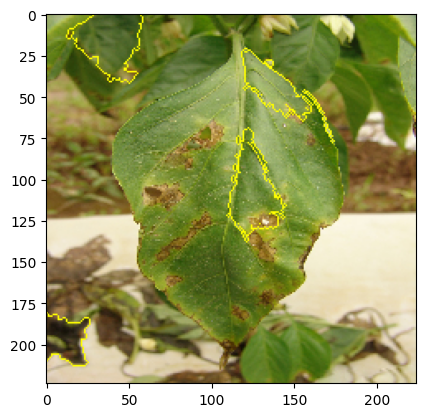

In [6]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=4, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

1/1 [==============================] - 0s 101ms/step
Top 3 Predicted Classes:
1. alternaria leaf spot: 0.9916185736656189
2. bacterial_wilt: 0.006844398565590382
3. bacterial blight: 0.0010960190556943417


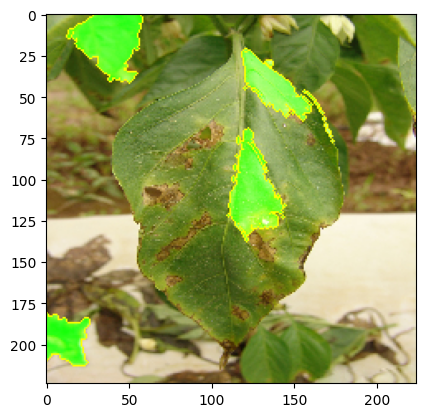

In [7]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=4, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

images = transform_img_fn([os.path.join(IMAGE)])
preds = MODEL.predict(images)

def display_class_probabilities(model, img_path, class_names):
    # Load and preprocess the input data
    img = image.load_img(img_path, target_size=(224, 224)) 
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Get class probabilities
    probabilities = model.predict(img_array)[0]

# Get indices of the top 3 predicted classes
    top3_indices = np.argsort(probabilities)[::-1][:3]

    # Display top 3 predicted classes with probabilities
    print("Top 3 Predicted Classes:")
    count = 1
    for i in top3_indices:
        print(f"{count}. {class_names[i]}: {probabilities[i]}")
        count += 1

display_class_probabilities(MODEL, IMAGE, CLASSES)
